In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt0
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split

import cv2

from google.colab.patches import cv2_imshow
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
# Sequential groups a linear stack of layers into a tf.keras.Model.
from tensorflow.keras.layers import Conv2D
# This layer creates a convolution kernel that is convolved with 
#  the layer input to produce a tensor of outputs.
from tensorflow.keras.layers import MaxPooling2D
# Max pooling operation for 2D spatial data.
from tensorflow.keras.layers import Flatten
# Flattens the input. Does not affect the batch size.
from tensorflow.keras.layers import Dense, Dropout
# Dropout: Applies Dropout to the input.
tensorflow.__version__                                                        
# Dense: Just your regular densely-connected NN layer.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'2.5.0'

## Import Data

In [2]:
filepath ="/content/drive/My Drive/Colab Notebooks/GL - University of Texas at Austin/07 - CNN Computer Vision_w3 Project/"
imagesnpy = "images.npy"
Labelscsv = "Labels.csv"
images = np.load(filepath+imagesnpy)
labels = pd.read_csv(filepath+Labelscsv)

## Shape

In [3]:
# Looks at the shape of Dependent and Independent variables 
print("X-shape: ",images.shape)
print("Y-shape: ",labels.shape)
print("Y-Label quantiy: ",labels.nunique(),"")

X-shape:  (4750, 128, 128, 3)
Y-shape:  (4750, 1)
Y-Label quantiy:  Label    12
dtype: int64 


In [4]:
# Capture Max intensity of the entire dataset.
maxIntensity = images.max()
maxIntensity

255

## Data Visualization

In [5]:
# Displays Grid of images based on X,y,tuple image size, grid size & intensity of the value.
def displayImgGrid( x_data ,Intensity,  y_data ,displayGrid,  imgSize  ):
  # Primes our grid template
  fig = plt.figure( figsize = imgSize )
  # print(displayGrid)
  # Taverses Rows
  for i in range( displayGrid[0] ):
    # Taverses Columns
    for j in range( displayGrid[1] ):
      # Qualifies if Intensity value is NOT Normalized
        # randomly selects values in the dataset
      random_index = np.random.randint( 0, len( x_data ) )
      ax = fig.add_subplot( displayGrid[0], displayGrid[1], (i * displayGrid[0]) + j + 1 )
      ax.set_title( y_data['Label'][random_index] )


      # Checks if not Normalized, if Normalized apply pixel intesity for show 
      # otherwise pixel intesity would not be accurate & we would only see an extreme
      if (images.max()>1):
        ax.imshow( x_data[random_index, :] )
      else:
        ax.imshow( Intensity * x_data[random_index, :] )
        # cv2_imshow( Intensity * x_data[random_index, :] )
  plt.show( )

In [6]:
def imageDetails(imageset,LABELING):
  for i in range(0, imageset.shape[0], imageset.shape[0]%4000):
    h, w = imageset[i].shape[:2]
    print('Image shape of image [',i ,'] is Height: {},  Width: {}'.format(h, w))
    print(LABELING['Label'][i], "[min:",imageset[i].min().astype('float32'), " MAX:", imageset[i].max().astype('float32'),']')
    print("-"*80)

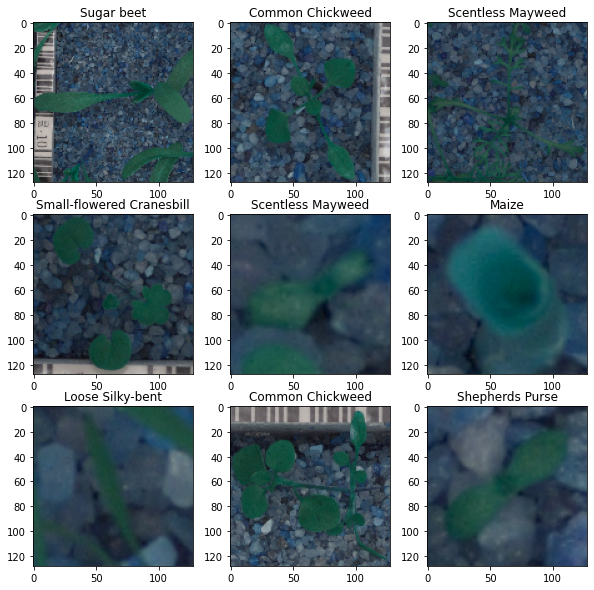

Image shape of image [ 0 ] is Height: 128,  Width: 128
Small-flowered Cranesbill [min: 2.0  MAX: 167.0 ]
--------------------------------------------------------------------------------
Image shape of image [ 750 ] is Height: 128,  Width: 128
Fat Hen [min: 0.0  MAX: 148.0 ]
--------------------------------------------------------------------------------
Image shape of image [ 1500 ] is Height: 128,  Width: 128
Common Chickweed [min: 0.0  MAX: 196.0 ]
--------------------------------------------------------------------------------
Image shape of image [ 2250 ] is Height: 128,  Width: 128
Charlock [min: 0.0  MAX: 183.0 ]
--------------------------------------------------------------------------------
Image shape of image [ 3000 ] is Height: 128,  Width: 128
Scentless Mayweed [min: 1.0  MAX: 216.0 ]
--------------------------------------------------------------------------------
Image shape of image [ 3750 ] is Height: 128,  Width: 128
Maize [min: 0.0  MAX: 233.0 ]
-----------------------

In [7]:
displayImgGrid(  images , images.max(),  labels, (3,3), (10,10) )
imageDetails(images, labels)

## Data Pre-Processing 
including Normalization Gaussian Blurring and Visuailizing again after the pre-processing

In [8]:
# Copy image set into a new variable which will be used for Normalizing their values
images_normalized = images.copy()

### Normalization

In [9]:
print("before: ", images_normalized.max())
if((images.astype('float32') / maxIntensity).all() <= 1):
  images_normalized = images.astype('float32') / maxIntensity
  # displayImgGrid(  images_normalized ,  labels )

print("after: ", images_normalized.max())

before:  255
after:  1.0


### Gaussian Blurring


In [10]:
# Copies normalized image set into a new variable which will be used for Gaussing Blur
images_normalized_GB = images_normalized.copy()

In [11]:
# Traverses the entire normalized image set & applies the Gaussian Blur  
for i in range(0, images_normalized.shape[0]):
  images_normalized_GB[i] = cv2.GaussianBlur(images_normalized[i], (35, 35), 0)

#### Post pre-processing Visualization

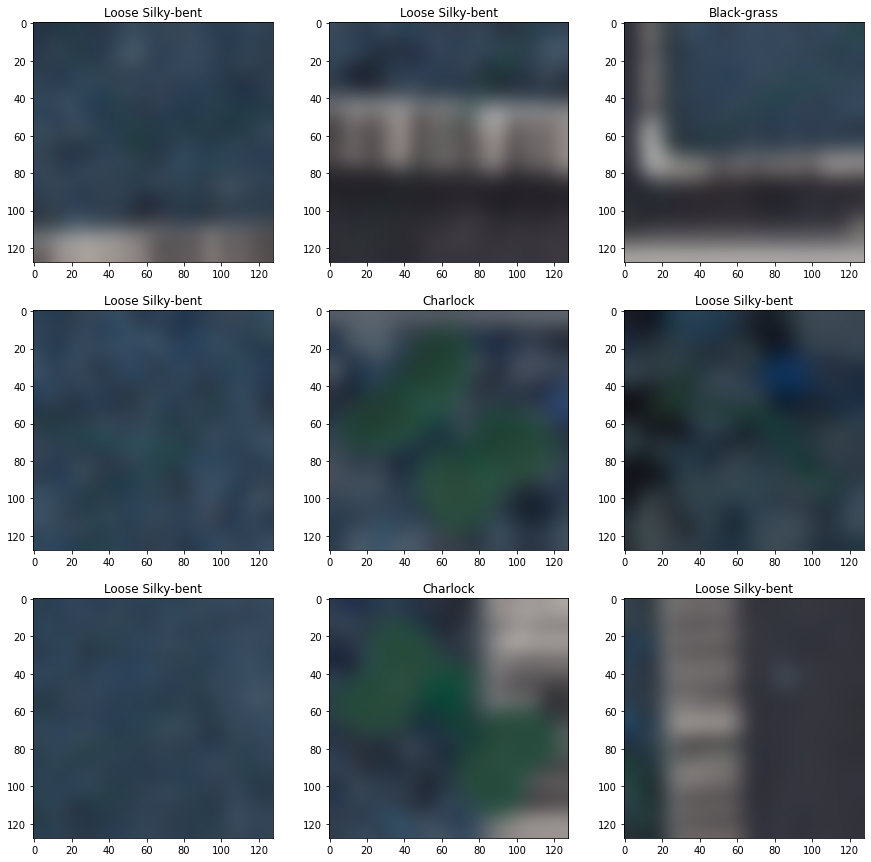

Image shape of image [ 0 ] is Height: 128,  Width: 128
Small-flowered Cranesbill [min: 0.06688523  MAX: 0.42429692 ]
--------------------------------------------------------------------------------
Image shape of image [ 750 ] is Height: 128,  Width: 128
Fat Hen [min: 0.100327395  MAX: 0.43512088 ]
--------------------------------------------------------------------------------
Image shape of image [ 1500 ] is Height: 128,  Width: 128
Common Chickweed [min: 0.08684435  MAX: 0.6092225 ]
--------------------------------------------------------------------------------
Image shape of image [ 2250 ] is Height: 128,  Width: 128
Charlock [min: 0.07834415  MAX: 0.44592786 ]
--------------------------------------------------------------------------------
Image shape of image [ 3000 ] is Height: 128,  Width: 128
Scentless Mayweed [min: 0.103754684  MAX: 0.7218074 ]
--------------------------------------------------------------------------------
Image shape of image [ 3750 ] is Height: 128,  Widt

In [12]:
displayImgGrid( images_normalized_GB,  images.max(), labels, (3,3), (15,15) )
imageDetails(images_normalized_GB, labels)

## Data Split

In [13]:
# Clarifying the X & y variables for split
y = labels.copy()
X = images_normalized_GB.copy()

# AT THIS POINT ALL NORMALIZATOIN & GAUSSIAN BLUR HAS BEEN COMPLETED

In [14]:
y.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4710,4711,4712,4713,4714,4715,4716,4717,4718,4719,4720,4721,4722,4723,4724,4725,4726,4727,4728,4729,4730,4731,4732,4733,4734,4735,4736,4737,4738,4739,4740,4741,4742,4743,4744,4745,4746,4747,4748,4749
Label,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,Small-flowered Cranesbill,...,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent,Loose Silky-bent


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.20, random_state=0)

print("-"*20,"SHAPE","-"*20)
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)

print("y_train:",y_train.shape)
print("y_test:",y_test.shape)


-------------------- SHAPE --------------------
X_train: (950, 128, 128, 3)
X_test: (3800, 128, 128, 3)
y_train: (950, 1)
y_test: (3800, 1)


In [16]:
imagesShape = X_train.shape[1:]
imagesShape

(128, 128, 3)

## Labels into One-Hot-Vectors

In [17]:
from sklearn.preprocessing import OneHotEncoder
y = pd.get_dummies(y)
y

,Label_Black-grass,Label_Charlock,Label_Cleavers,Label_Common Chickweed,Label_Common wheat,Label_Fat Hen,Label_Loose Silky-bent,Label_Maize,Label_Scentless Mayweed,Label_Shepherds Purse,Label_Small-flowered Cranesbill,Label_Sugar beet
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4745,0,0,0,0,0,0,1,0,0,0,0,0
4746,0,0,0,0,0,0,1,0,0,0,0,0
4747,0,0,0,0,0,0,1,0,0,0,0,0
4748,0,0,0,0,0,0,1,0,0,0,0,0


In [18]:
y.columns

Index(['Label_Black-grass', 'Label_Charlock', 'Label_Cleavers',
       'Label_Common Chickweed', 'Label_Common wheat', 'Label_Fat Hen',
       'Label_Loose Silky-bent', 'Label_Maize', 'Label_Scentless Mayweed',
       'Label_Shepherds Purse', 'Label_Small-flowered Cranesbill',
       'Label_Sugar beet'],
      dtype='object')

In [19]:
label_dict =  {
0:'_Black-grass'
,1:'_Charlock'
,2:'_Cleavers'
,3:'_Common Chickweed'
,4:'_Common wheat'
,5:'_Fat Hen'
,6:'_Loose Silky-bent'
,7:'_Maize'
,8:'_Scentless Mayweed'
,9:'_Shepherds Purse'
,10:'_Small-flowered Cranesbill'
,11:'_Sugar beet'}

In [20]:
"# Convert labels to one hot vectors."
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

## CNN Model 

### Build 

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
  # MaxPooling2D & MaxPool are the exact same thing, they are just aliases
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
model = Sequential()

# Adding Convolutional Layers with filters 32, 64, 128
model.add(Conv2D(filters = 128, kernel_size = (3,3),input_shape = imagesShape, activation = 'relu',))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

## This is the alternative way of adding Dense & Activation 
model.add(Dense(256,activation='relu'))
# Turn off 50% of neurons randomly to prevent overfitting
model.add(Dropout(0.5))
# Last layer, remember its multi-classification so we use softmax
model.add(Dense(12, activation="softmax"))

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer="adam")

print(len(model.layers),"layers")
model.summary()
# https://colab.research.google.com/drive/1UBi7erPDfQyxd_ZM8rfuy_3cUgnyRHjF?authuser=1#scrollTo=G7Q4W4_-DAkL

6 layers
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 508032)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               130056448 
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                3084      
Total params: 130,063,116
Trainable params: 130,063,116
Non-trainable params: 0
_________________________________

### Fit

In [23]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)
# Set early stop parameters for Model fitting 

In [24]:
# Fit the model
model.fit(
   x = X_train
  ,y = y_train
  ,validation_data = (X_test,y_test)
  ,validation_split = 0.2
  ,batch_size = None
  ,callbacks = [early_stop]
  ,epochs=30
)

Epoch 1/30
24/24 [==============================] - 46s 2s/step - loss: 6.1942 - accuracy: 0.1197 - val_loss: 2.3748 - val_accuracy: 0.2579
Epoch 2/30
24/24 [==============================] - 43s 2s/step - loss: 2.2460 - accuracy: 0.2263 - val_loss: 2.0269 - val_accuracy: 0.3263
Epoch 3/30
24/24 [==============================] - 43s 2s/step - loss: 1.9631 - accuracy: 0.3474 - val_loss: 1.7291 - val_accuracy: 0.3579
Epoch 4/30
24/24 [==============================] - 43s 2s/step - loss: 1.7944 - accuracy: 0.3961 - val_loss: 1.7287 - val_accuracy: 0.3789
Epoch 5/30
24/24 [==============================] - 43s 2s/step - loss: 1.6836 - accuracy: 0.4184 - val_loss: 1.5282 - val_accuracy: 0.4368
Epoch 6/30
24/24 [==============================] - 43s 2s/step - loss: 1.5426 - accuracy: 0.4474 - val_loss: 1.4870 - val_accuracy: 0.4474
Epoch 7/30
24/24 [==============================] - 43s 2s/step - loss: 1.4685 - accuracy: 0.5026 - val_loss: 1.4678 - val_accuracy: 0.4632
Epoch 8/30
24/24 [==

## Performance Evaluation

In [25]:
model.evaluate(X_test, y_test)

119/119 [==============================] - 43s 363ms/step - loss: 1.3712 - accuracy: 0.5497


[1.3711917400360107, 0.5497368574142456]

## Confusion Matrix

In [26]:
from sklearn.metrics import classification_report,confusion_matrix
mylist = 2,3,33,36,59

In [27]:
Predictions = model.predict_classes(X_test, batch_size=128, verbose=0)

In [28]:
mylist = 2,3,33,36,59
for i in mylist:
  print(Predictions[i])

6
6
6
6
8


In [29]:
# current state of y_test is an array instead of a single variable as 
for i in mylist:
  print(y_test[i])

[0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0]


In [30]:
# Confusion matrix does not accept (one-hot encoded), it requires y labels & predictions as integers 
# This requires them to be converted with .argmax & an axis of 1
newLabels = np.argmax(y_test, axis=1)
newLabels[1]

1

In [31]:
cm = confusion_matrix(newLabels, Predictions)
cm

array([[ 36,   0,   0,   1,   6,  16, 148,   1,   0,   0,   1,   4],
       [  0, 172,  14,  11,   0,  10,   1,   4,  48,   4,  29,  20],
       [  0,  23,  95,   3,   0,  20,   4,   0,  51,   0,  17,  12],
       [  0,   0,   1, 336,   0,  24,   2,  45,  52,   5,  10,  18],
       [ 11,   0,   7,   0,  18,  16, 107,   0,  25,   0,   0,   0],
       [  7,   3,   0,  35,   1, 145,  80,   6,  27,   2,  24,  36],
       [ 47,   1,   1,   1,   2,  11, 437,   0,   7,   0,   4,   6],
       [  0,   0,   0,  51,   0,   4,   3,  81,  28,   2,   2,   5],
       [  3,   3,   3,  37,   5,  13,  31,   5, 296,   2,   0,  13],
       [  0,   3,   0,  82,   0,   7,   0,  19,  43,   9,  33,   1],
       [  0,   7,   1,  24,   0,  15,   1,   5,   1,   2, 334,  14],
       [  2,   0,   1,  14,   3,  54,  20,   3,  57,   0,  17, 130]])

In [32]:
print("Predicted label:", Predictions.argmax())
print("Softmax Outputs:", Predictions)
print(Predictions.sum())

Predicted label: 14
Softmax Outputs: [6 1 6 ... 7 3 8]
23118


In [33]:
from google.colab.patches import cv2_imshow

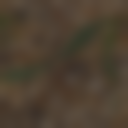

Predicted:_Loose Silky-bent 


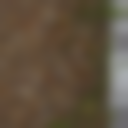

Predicted:_Charlock 


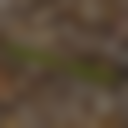

Predicted:_Loose Silky-bent 


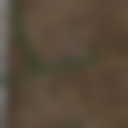

Predicted:_Loose Silky-bent 


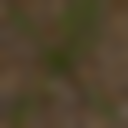

Predicted:_Fat Hen 


In [34]:
cv2_imshow(X_test[mylist[0]]*255)
print('Predicted:{} '.format(label_dict[Predictions[0]]))
cv2_imshow(X_test[mylist[1]]*255)
print('Predicted:{} '.format(label_dict[Predictions[1]]))
cv2_imshow(X_test[mylist[2]]*255)
print('Predicted:{} '.format(label_dict[Predictions[2]]))
cv2_imshow(X_test[mylist[3]]*255)
print('Predicted:{} '.format(label_dict[Predictions[3]]))
cv2_imshow(X_test[mylist[4]]*255)
print('Predicted:{} '.format(label_dict[Predictions[4]]))
